In [19]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
from collections import deque, defaultdict
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [20]:
#Extract real data
def connectivityExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df.replace(0, np.nan, inplace=True) #ensure all nonexistent vessels have NaN
    connectivity_df.at[0,'Parent']=0 #make sure first vessel is 0 (purposefully removed in last step for ease)
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'lengths' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'radius' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def volumeExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name + '.mat'
    matlab_data = scipy.io.loadmat(file_path)
    volume_raw = matlab_data['volumes']  # This is an x by 1 or 1D array
    volume_data = volume_raw.squeeze()  # Converts to 1D array if it's still 2D with 1 column
    volume_df = pd.DataFrame(volume_data, columns=['Volume'])
    return volume_df

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['Length'] #pull the length value
        radius = data.iloc[i]['Radius'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def assignDepth(data):
    tree = {} 
    for _, row in data.iterrows(): #iterate over every row
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist() #only select daughter values that exist
        tree[parent] = daughters
    # Step 2: BFS traversal to assign depths
    depths = {}
    queue = deque([(data['Parent'].iloc[0], 0)])  # Start from root (first parent)

    while queue:
        node, depth = queue.popleft()
        depths[node] = depth
        for child in tree.get(node, []):
            if child not in depths:  # Avoid revisiting
                queue.append((child, depth + 1))
    data['Depth'] = data['Parent'].map(depths)
    return data

def lengthFromRoot(data):
    tree = {}
    length_dict = dict(zip(data['Parent'], data['Length']))  # Map each vessel (parent) to its length

    for _, row in data.iterrows():
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist()
        tree[parent] = daughters

    # BFS traversal to calculate cumulative lengths
    lengths = {}
    root = data['Parent'].iloc[0]
    queue = deque([(root, 0)])  # Start with cumulative length 0

    while queue:
        node, cum_length = queue.popleft()
        lengths[node] = cum_length
        for child in tree.get(node, []):
            if child not in lengths:  # Avoid revisiting
                additional_length = length_dict.get(child, 0)
                queue.append((child, cum_length + additional_length))

    data['LengthFromRoot'] = data['Parent'].map(lengths)
    return data

def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'nodes' field
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'segments' field
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['Old', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def mapIDExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'mapID' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    map_raw = data_structure['mapIDs'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    map_data = map_raw.squeeze()
    # Create a DataFrame from the connectivity data
    map_df = pd.DataFrame(map_data, columns=['New', 'Old'])
    # Save the DataFrame to inspect it
    return map_df

def tortuosityCalculator(data,name):
    nodes = nodesExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    tortuosity = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        old_vesID = maps.iloc[i]['Old'] #find the old vessel ID
        edge_row = edges.index.get_loc(edges[edges['Old'] == old_vesID].index[0])
        node1 = edges.iloc[edge_row]['From'] #identify from node
        node2 = edges.iloc[edge_row]['To'] #identify to node
        node1_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node1].index[0])
        node2_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node2].index[0])
        node1_x = nodes.iloc[node1_row]['X'] #pull node 3d coordinate
        node1_y = nodes.iloc[node1_row]['Y']
        node1_z = nodes.iloc[node1_row]['Z']
        node2_x = nodes.iloc[node2_row]['X']
        node2_y = nodes.iloc[node2_row]['Y']
        node2_z = nodes.iloc[node2_row]['Z']
        euclid_dist = math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2 + (node1_z - node2_z)**2) #calculate euclidean distance between from and to
        length = data.iloc[i]['Length'] #pull length and convert to mm
        ratio = length/euclid_dist #find tortuosity ratio
        tortuosity = np.append(tortuosity,ratio)
    data['Tortuosity'] = tortuosity.tolist() #add to table
    return data

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):# iterate over every row
        dv1 = data.iloc[i]['Daughter1'] #pull radii values
        dv2 = data.iloc[i]['Daughter2']
        dv3 = data.iloc[i]['Daughter3']
        if math.isnan(dv1): #if daughter vessel 1 doesn't exist, none of them do
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if math.isnan(dv3): #explicitly check whetehr dv3 exist
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    #select and reorder columns
    data = data.loc[:,['Parent','Depth','Length','Radius','Volume', 'Length/Radius','LengthFromRoot','Tortuosity','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #check if trifurcation, if it is then don't calculate
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R']
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #check if daughter vessels exist
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r: #case 1 of daughter vessels
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else: #case 2 of daughter vessels
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i]['Radius']/1000 #pull all radii and convert to mm
        rd1 = data.iloc[i]['DV1R']/1000
        rd2 = data.iloc[i]['DV2R']/1000
        rd3 = data.iloc[i]['DV3R']/1000
        if not math.isnan(rd3): #don't calculate if trifucation
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1): #don't calculate if no daughter vessels
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        xi = 2.5
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-3: #allow for error up to 10^-4
            fun = rp**xi - rd1**xi - rd2**xi # solve at f(xi)
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2) #solve at f'(xi)
            xi = xi - fun/fun2 # new xi value
            error = rp**xi - rd1**xi - rd2**xi #calculate new error
        if xi > 4: #bound xi
            xi = 4
        if xi < 2:
            xi = 2
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi'] = xi_values.tolist()#add xi to the table
    #data['Error Newton'] = error_values.tolist()
    return data

def asymmetry(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #don't calculate if trifucation
            asym = np.append(asym,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull radii
        dv2r = data.iloc[i]['DV2R']
        if math.isnan(dv1r): #if no daughters, skip
            asym = np.append(asym,np.nan)
            continue
        if dv1r>=dv2r: #case 1
            asym_value = (dv2r/dv1r)**2
        else: #case 2
            asym_value = (dv1r/dv2r)**2
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def area(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #if trifucation, skip
            area = np.append(area,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull necessary radii
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #if no daughters, skip
            area = np.append(area,np.nan)
            continue
        area_value = (dv1r**2+dv2r**2)/(pv**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def angleExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    angles = matlab_data['Angles']
    headers = [str(h.item()) if isinstance(h,np.ndarray) else str(h) for h in angles[0]]
    columns = [angles[1,i].squeeze() for i in range(len(headers))]
    angled = pd.DataFrame(dict(zip(headers,columns)))
    return angled

def matchAngles(data,name):
    angles = angleExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, edges, on='Old', how='left')
    angleID = pd.merge(newOldIDs,angles,left_on='To',right_on='hubNode')
    angleID.drop(['Old','From','To','hubNode'],axis=1,inplace=True)
    #vesAngle = angleID.merge(data,left_on='New',right_on='Parent',how='left')
    angled = data.merge(angleID,left_on='Parent',right_on='New',how='left')
    angled = angled.drop(columns='New')
    return angled

def dataExtractor(name): #sequentially calls necessary functions to create full table
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    volume = volumeExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, volume, connectivity.iloc[:, 1:]], axis=1)
    lengthradius = lRR(combined)
    #print('LRR')
    depthness = assignDepth(lengthradius)
    #print('Depth')
    lengthTotal = lengthFromRoot(depthness)
    #print('LengthFromRoot')
    tortuos = tortuosityCalculator(lengthTotal,name)
    #print('Tortousity')
    allradii = radiusFinder(tortuos)
    angled = matchAngles(allradii,name)
    alphabetazed = alphaBeta(angled)
    #print('Alpha/beta')
    xi = xiFinder(alphabetazed)
    #print('Xi')
    asymmetric = asymmetry(xi)
    #print('Gamma')
    areated = area(asymmetric)
    return areated

def saveStatistics(name): #saves the stats as .csv for exporting
    statistics = dataExtractor(name)[["Parent", "Depth",'Length','Radius','Volume','Length/Radius','LengthFromRoot','Tortuosity','Alpha','Beta','Xi','Gamma','Eta']] #selects correct columns
    file_path = 'Statistics/Statistics_' + name +'.csv'
    statistics.to_csv(file_path) #shouldn't return anything, just save

def leaveDetails(statistics,name):
    #statistics = dataExtractor(name)
    dropped = statistics.dropna(subset='DV1R')
    internal = dropped.shape[0]
    tris = dropped['DV3R'].count()
    leaves = statistics['DV1R'].isna().sum()
    triratio = tris/internal * 100
    avgdepth = statistics[statistics['Daughter1'].isna()]['Depth'].mean()
    stddepth = statistics[statistics['Daughter1'].isna()]['Depth'].std()
    volume = statistics['Volume'].sum()/(1000**3)
    print(name)
    print('# of vessels: ' + str(statistics.shape[0]))
    print('# of leaves (terminal vessels): ' + str(leaves))
    print('# of internal vessels: ' + str(internal))
    print('# of trifurcations: '+ str(tris))
    print('% of trifurcations: ' + str(round(triratio,3)))
    print('Volume (mm^3): ' + str(round(volume,3)))
    print('Average Depth of terminal vessel: ' + str(round(avgdepth,3)))
    print('St. Dev. Depth of terminal vessel: ' + str(round(stddepth,3)))


In [44]:
#Extract generated data
def lRRg(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['l'] #pull the length value
        radius = data.iloc[i]['r'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def alphaBetag(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        bl = data.iloc[i]['bl']
        br = data.iloc[i]['br']
        if data.iloc[i]['dl'] == -10:
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if bl>=br: #case 1 of daughter vessels
            alpha_value = bl
            beta_value = br
        else: #case 2 of daughter vessels
            alpha_value = br
            beta_value = bl
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def asymmetryg(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if data.iloc[i]['dl'] == -10: 
            asym = np.append(asym,np.nan)
            continue
        a = data.iloc[i]['Alpha'] #pull radii
        b = data.iloc[i]['Beta']
        asym_value = (b**2)/(a**2)
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def areag(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if data.iloc[i]['dl'] == -10: 
            area = np.append(area,np.nan)
            continue
        a = data.iloc[i]['Alpha'] #pull radii
        b = data.iloc[i]['Beta']
        area_value = (a**2+b**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def generatedExtractor(name,num):
    spreadsheet = pd.read_csv('Generated/'+name+'_vessels_generated_'+str(num)+'.csv')
    lrr = lRRg(spreadsheet)
    alphabetazed = alphaBetag(lrr)
    asymmetric = asymmetryg(alphabetazed)
    areated = areag(asymmetric)
    areated['Length'] = areated['l']*1000
    areated['Radius'] = areated['r']*1000
    final = areated.loc[:,['Length','Radius','Length/Radius','Alpha','Beta','Gamma','Eta']]
    return final

In [30]:
def lobeExtractor(name, vesID):
    data = dataExtractor(name)
    
    tree = defaultdict(list)
    for _,row in data.iterrows():
        parent = row['Parent']
        for daughter_col in ['Daughter1','Daughter2','Daughter3']:
            daughter = row[daughter_col]
            if pd.notna(daughter):
                tree[parent].append(daughter)

    visited = set()
    queue = deque([vesID])

    while queue:
        current = queue.popleft()
        if current not in visited:
            visited.add(current)
            queue.extend(tree.get(current,[]))
    
    downstream_df = data[data['Parent'].isin(visited) | data['Parent'].isin([vesID])]
    return downstream_df.reset_index()


def lobeInput(name,fromnode,tonode):
    segments = edgesExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, segments, on='Old', how='left')
    newVesID = int(newOldIDs[((newOldIDs['From'] == fromnode)&(newOldIDs['To']==tonode))].iloc[0,0])
    lobe = lobeExtractor(name,newVesID)
    return lobe    

def bintoPlot(data,total,x):
    #filtered = data[(data['Radius'] < 0.4 * total['Radius'][0]) & (data['Radius'] > 0.2 * total['Radius'][0])]
    filtered = data[data['Radius'] < .4*total['Radius'][0]]
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Radius'].mean()
    b = filtered.groupby('binned')[x].mean()
    return a,b

def exponential(x, a, b):
    return a * np.exp(-b * x)
    #return a*(x**-b)

def percOPP(data):
    opp = offPrincipalPath(data)
    print(opp.shape[0])
    percent = opp.shape[0]/data.shape[0]*100
    return percent

In [31]:
hyper1 = dataExtractor('m1p4_053007')
h1_left = lobeInput('m1p4_053007',1810,1811)
hyper2 = dataExtractor('m2p4_053007')
h2_left = lobeInput('m2p4_053007',1209,1214)
hyper3 = dataExtractor('m1p4_053107')
h3_left = lobeInput('m1p4_053107',1252,2103)
hyper4 = dataExtractor('m2p4_053107')
h4_left = lobeInput('m2p4_053107',1239,1392)
hyper5 = dataExtractor('m1p4_060107')
h5_left = lobeInput('m1p4_060107',215,1664)

In [45]:
h1g = generatedExtractor('m1p4_053007',200)
h2g = generatedExtractor('m2p4_053007',200)
h3g = generatedExtractor('m1p4_053107',200)
h4g = generatedExtractor('m2p4_053107',200)
h5g = generatedExtractor('m1p4_060107',200)

# Left Lobe

In [46]:
h1gr,h1gl = bintoPlot(h1g,hyper1,'Length/Radius')
h1rr,h1rl = bintoPlot(h1_left,hyper1,'Length/Radius')
h2gr,h2gl = bintoPlot(h2g,hyper2,'Length/Radius')
h2rr,h2rl = bintoPlot(h2_left,hyper2,'Length/Radius')
h3gr,h3gl = bintoPlot(h3g,hyper3,'Length/Radius')
h3rr,h3rl = bintoPlot(h3_left,hyper3,'Length/Radius')
h4gr,h4gl = bintoPlot(h4g,hyper4,'Length/Radius')
h4rr,h4rl = bintoPlot(h4_left,hyper4,'Length/Radius')
h5gr,h5gl = bintoPlot(h5g,hyper5,'Length/Radius')
h5rr,h5rl = bintoPlot(h5_left,hyper5,'Length/Radius')


In [47]:
hyprlrr = np.concatenate((h1rl,h2rl,h3rl,h4rl,h5rl),axis=0)
hyprr = np.concatenate((h1rr,h2rr,h3rr,h4rr,h5rr),axis=0)
hypglrr = np.concatenate((h1gl,h2gl,h3gl,h4gl,h5gl),axis=0)
hypgr = np.concatenate((h1gr,h2gr,h3gr,h4gr,h4gl),axis=0)

paramshrlrr, _ = curve_fit(exponential, hyprr, hyprlrr,p0=[10, 0.008])
paramshglrr, _ = curve_fit(exponential, hypgr, hypglrr,p0=[10, 0.008])

x_range = np.linspace(min(hyprr),max(hyprr), 400)

hrlrr_fit = exponential(x_range, *paramshrlrr)
hglrr_fit = exponential(x_range, *paramshglrr)

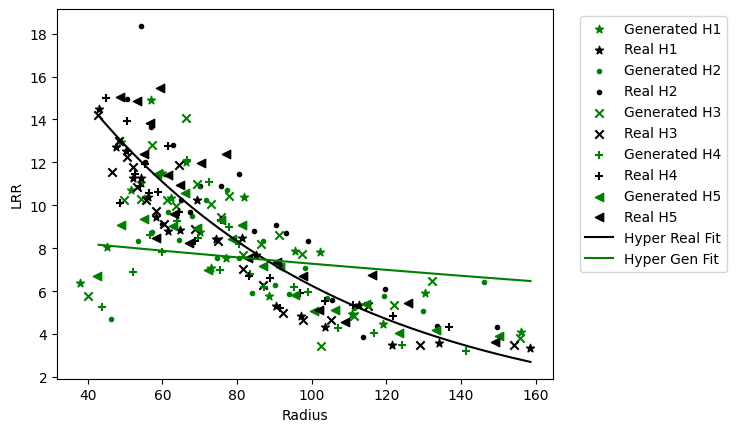

In [48]:
plt.scatter(h1gr,h1gl, c='g', marker='*', label='Generated H1')
plt.scatter(h1rr,h1rl, c='k', marker='*', label='Real H1')
plt.scatter(h2gr,h2gl, c='g', marker='.', label='Generated H2')
plt.scatter(h2rr,h2rl, c='k', marker='.', label='Real H2')
plt.scatter(h3gr,h3gl, c='g', marker='x', label='Generated H3')
plt.scatter(h3rr,h3rl, c='k', marker='x', label='Real H3')
plt.scatter(h4gr,h4gl, c='g', marker='+', label='Generated H4')
plt.scatter(h4rr,h4rl, c='k', marker='+', label='Real H4')
plt.scatter(h5gr,h5gl, c='g', marker='<', label='Generated H5')
plt.scatter(h5rr,h5rl, c='k', marker='<', label='Real H5')
plt.plot(x_range, hrlrr_fit, color='k', linestyle='-', label='Hyper Real Fit')
plt.plot(x_range, hglrr_fit, color='g', linestyle='-', label='Hyper Gen Fit')
plt.ylabel('LRR')
plt.xlabel('Radius')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

# Whole Lung

In [ ]:
c1p4_whole = lobeInput('m1p4_060407',44,45)
c2p4_whole = lobeInput('m2p4_060407',515,727)
c3p4_whole = lobeInput('m3p4_060407',326,939)
h1p4_whole = lobeInput('m1p4_053007',23,1809)
h2p4_whole = lobeInput('m2p4_053007',184,1240)
h3p4_whole = lobeInput('m1p4_053107',43,2565)

In [ ]:
c1p4wr,c1p4wl = bintoPlot(c1p4_whole,control1p4,'Length/Radius')
c2p4wr,c2p4wl = bintoPlot(c2p4_whole,control2p4,'Length/Radius')
c3p4wr,c3p4wl = bintoPlot(c3p4_whole,control3p4,'Length/Radius')
h1p4wr,h1p4wl = bintoPlot(h1p4_whole,hyper1p4,'Length/Radius')
h2p4wr,h2p4wl = bintoPlot(h2p4_whole,hyper2p4,'Length/Radius')
h3p4wr,h3p4wl = bintoPlot(h3p4_whole,hyper3p4,'Length/Radius')

In [ ]:
controlwlrr = np.concatenate((c1p4wl,c2p4wl,c3p4wl),axis=0)
controlwr = np.concatenate((c1p4wr,c2p4wr,c3p4wr),axis=0)
hypwlrr = np.concatenate((h1p4wl,h2p4wl,h3p4wl),axis=0)
hypwr = np.concatenate((h1p4wr,h2p4wr,h3p4wr),axis=0)

paramscwlrr, _ = curve_fit(exponential, controlwr, controlwlrr,p0=[10, 0.01])
paramshwlrr, _ = curve_fit(exponential, hypwr, hypwlrr,p0=[10, 0.01])

print(paramscwlrr)

x_range = np.linspace(45,400, 355)

cwlrr_fit = exponential(x_range, *paramscwlrr)
hwlrr_fit = exponential(x_range, *paramshwlrr)

In [ ]:
plt.scatter(c3p4wr,c3p4wl, c='r', marker='x', label='Real C3P4')
plt.scatter(c1p4wr,c1p4wl, c='r', marker='*', label='Real C1P4')
plt.scatter(c2p4wr,c2p4wl, c='r', marker='.', label='Real C2P4')
plt.scatter(h1p4wr,h1p4wl, c='k', marker='*', label='Real H1P4')
plt.scatter(h2p4wr,h2p4wl, c='k', marker='.', label='Real H2P4')
plt.scatter(h3p4wr,h3p4wl, c='k', marker='x', label='Real H3P4')
plt.plot(x_range, cwlrr_fit, color='red', linestyle='--', label='Control Whole Fit')
plt.plot(x_range, hwlrr_fit, color='k', linestyle='-', label='Hyper Whole Fit')
plt.ylabel('LRR')
plt.xlabel('Radius')
plt.xlim([45, 180])
plt.ylim([-1,15])
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

try raw data
focus on left lobe
on vs off principle pathway
use all mice